# Applying different inclusion criteria to Brain Observatory dataset

## Calcium imaging studies use inclusion criteria to select for responsive, tuned cells. This notebook applies inclusion criteria used in previous calcium imaging physiological studies of the tuning properties of mouse visual cortex to the Allen Institute Brain Observatory dataset.


###### The 2-photon calcium imaging data used in this analysis can be accessed at https://observatory.brain-map.org/visualcoding/overview




In [1]:


# Import dependencies
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os 
import tifffile as tiff
import seaborn as sns
import pandas as pd
from scipy.signal import butter, lfilter, bessel, ellip, firwin, filtfilt, get_window
import tables as tb
from scipy import ndimage
from scipy import misc 
import cv2
from ipywidgets import interact


# import necessary allensdk packages
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.brain_observatory.drifting_gratings import DriftingGratings

%matplotlib inline



In [2]:

# obtains all expeirments from Cux2-CreERT2 and Slc17a7 animals
manifest_file_path = r"D:\platform_boc_2018_09_25\manifest.json" # path to brain observatory manifest locally
ophys_experiment_path = r"D:\platform_boc_2018_09_25\ophys_experiment_data" # path to brain observatory ophys experimental data locally
boc = BrainObservatoryCache(manifest_file= manifest_file_path)


In [3]:
# get all experiments from Cux2 and Slc17a7 mice in brain observatory
cux2_ecs = boc.get_experiment_containers(cre_lines=['Cux2-CreERT2','Slc17a7-IRES2-Cre'], reporter_lines = ['Ai93(TITL-GCaMP6f)','Ai93(TITL-GCaMP6f)-hyg'], imaging_depths = [276,275, 285, 265])


cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

cux2_ec_ids = [ ec['id'] for ec in cux2_ecs ]
cux2_cells = cells[cells['experiment_container_id'].isin(cux2_ec_ids)]

cell_exp = boc.get_ophys_experiments(cell_specimen_ids=cux2_cells['cell_specimen_id'].values,
                                     stimuli=[stim_info.DRIFTING_GRATINGS])


In [4]:
# creates dataframe of all cells from experiments chosen above
cell_dat = pd.DataFrame(columns = ['cell_specimen_id',
                                          'id',
                                          'area',
                                          'reliability',
                                          'reliability_marshel',
                                          'reliability_corr',
                                          'DSI',
                                          'OSI',
                                          'gOSI',
                                          'TF',
                                          'pref_ori',
                                          'peak dF/F', 
                                          'Tohmi', 
                                          'Marshel',
                                          'Andermann', 
                                          'Roth', 
                                          'Sun'])
for exp in cell_exp:     
    print("Experiment with drifting gratings:")
    pprint.pprint(exp)
    cell_exp_dat = pd.DataFrame(columns = ['cell_specimen_id',
                                          'id',
                                          'area',
                                          'reliability',
                                          'reliability_marshel',
                                          'reliability_corr',
                                          'DSI',
                                          'OSI',
                                          'gOSI',
                                          'TF',
                                          'pref_ori',
                                          'peak dF/F', 
                                          'Tohmi', 
                                          'Marshel',
                                          'Andermann', 
                                          'Roth', 
                                          'Sun'])    

    data_set = boc.get_ophys_experiment_data(exp['id'])
    dg = DriftingGratings(data_set)
    stim_table = dg.stim_table

    print cell_exp_dat.head()
    # create dataframe with reliability, peak dF/F, and whether they passed each criterion
    
    cell_exp_dat['DSI'] = dg.peak.dsi_dg
    cell_exp_dat['pref_ori'] = dg.peak.ori_dg
    cell_exp_dat['OSI'] = dg.peak.osi_dg
    cell_exp_dat['gOSI'] = cells[cells['experiment_container_id'] == exp['experiment_container_id']].g_osi_dg
    cell_exp_dat['TF'] = dg.peak.tf_dg
    cell_exp_dat['reliability'] = dg.peak.reliability_dg
    cell_exp_dat['peak dF/F'] = dg.peak.peak_dff_dg
    cell_exp_dat['Sun'] = cell_exp_dat['peak dF/F']> 10
    cell_exp_dat['id'] = exp['id']
    cell_exp_dat['area'] = exp['targeted_structure']
    for cell in range(dg.numbercells):
        # Andermann
        pref_tf = dg.tfvals[dg.peak.tf_dg.iloc[cell]]
        pref_ori = dg.orivals[dg.peak.ori_dg.iloc[cell]]
        resp_tf = dg.mean_sweep_response[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)][str(cell)].values
        resp_blank = dg.mean_sweep_response[stim_table['blank_sweep']==True][str(cell)].values
        t2, p2 = sc.stats.ttest_ind(resp_tf,resp_blank)
        cell_exp_dat['p_blank'] = p2
        cell_exp_dat['Andermann'].iloc[cell] = p2 < 0.05/40
        
        # Marshel 
        stdev_tf = sc.std(resp_tf)
        mean_tf = np.mean(resp_tf)
        stdev_blank = sc.std(resp_blank)
        mean_blank = np.mean(resp_blank)
        reliability = (mean_tf- mean_blank) / (stdev_tf + stdev_blank)
        cell_exp_dat['Marshel'].iloc[cell] = (reliability > 1) 
        cell_exp_dat['reliability_marshel'].iloc[cell] = reliability
        
        #Roth
        resp_baseline = dg.sweep_response[str(cell)].apply(lambda x : x[:30])
        resp = dg.sweep_response[str(cell)].apply(lambda x : x[30:90])
        resp_baseline_mean  = resp_baseline.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        resp_baseline_std = resp_baseline.apply(np.std)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        resp_mean = resp.apply(np.mean)[(stim_table['temporal_frequency']== pref_tf) & (stim_table['orientation']== pref_ori)]
        cell_exp_dat['Roth'].iloc[cell] = np.sum((resp_mean > (resp_baseline_mean + resp_baseline_std*3)))/np.float(resp_baseline_mean.shape[0])>0.5
        cell_exp_dat['reliability_percentage'] = np.sum(resp_mean > (resp_baseline_mean + resp_baseline_std*2))/np.float(resp_baseline_mean.shape[0])
        
        # Tohmi 
        sweep_resp_pref = dg.sweep_response[(stim_table.orientation==pref_ori) & (stim_table.temporal_frequency==pref_tf)][str(cell)]
        mean_sweep_resp_pref = sweep_resp_pref.mean()
        max_resp = mean_sweep_resp_pref[30:90].max()
        cell_exp_dat['Tohmi'].iloc[cell] = max_resp > 4
        
        

    cell_dat = cell_dat.append(cell_exp_dat)
    del cell_exp_dat



Experiment with drifting gratings:
{'acquisition_age_days': 95,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355467',
 'experiment_container_id': 652736297,
 'fail_eye_tracking': True,
 'id': 653123929,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355467',
 'targeted_structure': u'VISl'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 132,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382423',
 'experiment_container_id': 708949511,
 'fail_eye_tracking': True,
 'id': 712919665,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423',
 'targeted_structure': u'VISam'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 145,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'356797',
 'experiment_container_id': 657014785,
 'fail_eye_tracking': True,
 'id': 662359728,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356797',
 'targeted_structure': u'VISpm'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 101,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'225036',
 'experiment_container_id': 511510779,
 'fail_eye_tracking': True,
 'id': 503109347,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036',
 'targeted_structure': u'VISp'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 102,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'243293',
 'experiment_container_id': 524691282,
 'fail_eye_tracking': True,
 'id': 524691284,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-243293',
 'targeted_structure': u'VISp'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 91,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'233215',
 'experiment_container_id': 511854338,
 'fail_eye_tracking': True,
 'id': 512326618,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-233215',
 'targeted_structure': u'VISal'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 107,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'369311',
 'experiment_container_id': 672207945,
 'fail_eye_tracking': True,
 'id': 672207947,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-369311',
 'targeted_structure': u'VISl'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 103,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222420',
 'experiment_container_id': 511510667,
 'fail_eye_tracking': True,
 'id': 501574836,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420',
 'targeted_structure': u'VISp'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 123,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355537',
 'experiment_container_id': 656939125,
 'fail_eye_tracking': True,
 'id': 657080632,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355537',
 'targeted_structure': u'VISp'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 86,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'228379',
 'experiment_container_id': 511510867,
 'fail_eye_tracking': True,
 'id': 505407318,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228379',
 'targeted_structure': u'VISal'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 89,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'348262',
 'experiment_container_id': 645413757,
 'fail_eye_tracking': True,
 'id': 645413759,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-348262',
 'targeted_structure': u'VISp'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 140,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'283284',
 'experiment_container_id': 566759225,
 'fail_eye_tracking': False,
 'id': 570305847,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284',
 'targeted_structure': u'VISam'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 90,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'339323',
 'experiment_container_id': 638056632,
 'fail_eye_tracking': True,
 'id': 627823344,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-339323',
 'targeted_structure': u'VISal'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 116,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'282817',
 'experiment_container_id': 566307034,
 'fail_eye_tracking': False,
 'id': 566307038,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282817',
 'targeted_structure': u'VISam'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 120,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'333422',
 'experiment_container_id': 614561352,
 'fail_eye_tracking': True,
 'id': 637154333,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-333422',
 'targeted_structure': u'VISrl'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 90,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229106',
 'experiment_container_id': 511510940,
 'fail_eye_tracking': False,
 'id': 507691036,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229106',
 'targeted_structure': u'VISpm'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 90,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'347748',
 'experiment_container_id': 644013840,
 'fail_eye_tracking': True,
 'id': 645256361,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347748',
 'targeted_structure': u'VISl'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 104,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'373869',
 'experiment_container_id': 679702882,
 'fail_eye_tracking': True,
 'id': 679702884,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-373869',
 'targeted_structure': u'VISp'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 84,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'389531',
 'experiment_container_id': 710502979,
 'fail_eye_tracking': True,
 'id': 710502981,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-389531',
 'targeted_structure': u'VISrl'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 88,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'389015',
 'experiment_container_id': 710469197,
 'fail_eye_tracking': True,
 'id': 710469199,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-389015',
 'targeted_structure': u'VISam'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 141,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'356796',
 'experiment_container_id': 659746623,
 'fail_eye_tracking': True,
 'id': 661328410,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356796',
 'targeted_structure': u'VISp'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 142,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'356797',
 'experiment_container_id': 658854759,
 'fail_eye_tracking': True,
 'id': 662348804,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356797',
 'targeted_structure': u'VISl'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 117,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382423',
 'experiment_container_id': 702208910,
 'fail_eye_tracking': True,
 'id': 706566686,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423',
 'targeted_structure': u'VISrl'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 105,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382421',
 'experiment_container_id': 702934962,
 'fail_eye_tracking': True,
 'id': 702934964,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421',
 'targeted_structure': u'VISp'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 101,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'273576',
 'experiment_container_id': 556936291,
 'fail_eye_tracking': True,
 'id': 558670888,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-273576',
 'targeted_structure': u'VISal'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 95,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355470',
 'experiment_container_id': 653122665,
 'fail_eye_tracking': True,
 'id': 653122667,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355470',
 'targeted_structure': u'VISp'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 97,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'382421',
 'experiment_container_id': 699155263,
 'fail_eye_tracking': True,
 'id': 699155265,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421',
 'targeted_structure': u'VISl'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 98,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'390323',
 'experiment_container_id': 716655272,
 'fail_eye_tracking': True,
 'id': 716956096,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-390323',
 'targeted_structure': u'VISpm'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 102,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'340467',
 'experiment_container_id': 639253041,
 'fail_eye_tracking': True,
 'id': 639931541,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-340467',
 'targeted_structure': u'VISal'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 88,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229109',
 'experiment_container_id': 511510848,
 'fail_eye_tracking': False,
 'id': 506823562,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229109',
 'targeted_structure': u'VISl'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 125,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'308148',
 'experiment_container_id': 593902385,
 'fail_eye_tracking': True,
 'id': 595229536,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148',
 'targeted_structure': u'VISam'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 98,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'384940',
 'experiment_container_id': 702956471,
 'fail_eye_tracking': True,
 'id': 704822876,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-384940',
 'targeted_structure': u'VISl'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 85,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'231585',
 'experiment_container_id': 511510870,
 'fail_eye_tracking': False,
 'id': 509958730,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231585',
 'targeted_structure': u'VISl'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 130,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'360565',
 'experiment_container_id': 658534530,
 'fail_eye_tracking': True,
 'id': 663866413,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565',
 'targeted_structure': u'VISpm'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 127,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'355537',
 'experiment_container_id': 657391035,
 'fail_eye_tracking': True,
 'id': 657391037,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355537',
 'targeted_structure': u'VISpm'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 94,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'228378',
 'experiment_container_id': 511511052,
 'fail_eye_tracking': True,
 'id': 507464107,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228378',
 'targeted_structure': u'VISal'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 87,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'385254',
 'experiment_container_id': 701046698,
 'fail_eye_tracking': True,
 'id': 701046700,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-385254',
 'targeted_structure': u'VISpm'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 117,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'360565',
 'experiment_container_id': 659767480,
 'fail_eye_tracking': True,
 'id': 660513003,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565',
 'targeted_structure': u'VISp'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 99,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'231585',
 'experiment_container_id': 511856567,
 'fail_eye_tracking': False,
 'id': 512164988,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231585',
 'targeted_structure': u'VISal'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 97,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'339323',
 'experiment_container_id': 698102441,
 'fail_eye_tracking': True,
 'id': 638056634,
 'imaging_depth': 276,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-339323',
 'targeted_structure': u'VISal'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 85,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'390323',
 'experiment_container_id': 712178509,
 'fail_eye_tracking': True,
 'id': 712178511,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-390323',
 'targeted_structure': u'VISp'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 114,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'372079',
 'experiment_container_id': 679700455,
 'fail_eye_tracking': True,
 'id': 679700458,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-372079',
 'targeted_structure': u'VISpm'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 104,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'361636',
 'experiment_container_id': 658536109,
 'fail_eye_tracking': True,
 'id': 658536111,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-361636',
 'targeted_structure': u'VISp'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 102,
 'cre_line': u'Slc17a7-IRES2-Cre',
 'donor_name': u'347751',
 'experiment_container_id': 647155120,
 'fail_eye_tracking': True,
 'id': 647155122,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347751',
 'targeted_structure': u'VISp'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 94,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'354074',
 'experiment_container_id': 652094915,
 'fail_eye_tracking': True,
 'id': 652094917,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-354074',
 'targeted_structure': u'VISam'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 91,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229107',
 'experiment_container_id': 511510945,
 'fail_eye_tracking': False,
 'id': 507990552,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229107',
 'targeted_structure': u'VISl'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 117,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'360566',
 'experiment_container_id': 660510591,
 'fail_eye_tracking': True,
 'id': 660510593,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360566',
 'targeted_structure': u'VISrl'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 85,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'229109',
 'experiment_container_id': 511510836,
 'fail_eye_tracking': False,
 'id': 505845219,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229109',
 'targeted_structure': u'VISpm'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 122,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'244898',
 'experiment_container_id': 529487170,
 'fail_eye_tracking': True,
 'id': 529688779,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-244898',
 'targeted_structure': u'VISl'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 136,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'283284',
 'experiment_container_id': 570008442,
 'fail_eye_tracking': False,
 'id': 570008444,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284',
 'targeted_structure': u'VISrl'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 120,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'308148',
 'experiment_container_id': 592349242,
 'fail_eye_tracking': True,
 'id': 593552712,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148',
 'targeted_structure': u'VISrl'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

Experiment with drifting gratings:
{'acquisition_age_days': 96,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'225037',
 'experiment_container_id': 511510699,
 'fail_eye_tracking': True,
 'id': 502608215,
 'imaging_depth': 275,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037',
 'targeted_structure': u'VISp'}
Empty DataFrame
Columns: [cell_specimen_id, id, area, reliability, reliability_marshel, reliability_corr, DSI, OSI, gOSI, TF, pref_ori, peak dF/F, Tohmi, Marshel, Andermann, Roth, Sun]
Index: []


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

In [27]:
n = 0
for exp in cell_exp:
    print exp
    #cell_specimen_df = pd.DataFrame(columns = ['cell_specimen_id'])
    data_set = boc.get_ophys_experiment_data(exp['id'])
    dg = DriftingGratings(data_set)
    ncells = dg.numbercells
    #reliability_percentage = pd.DataFrame(index = np.arange(dg.numbercells), columns = ['reliability_percentage'])
    cell_dat['cell_specimen_id'][n:n+ncells] = dg.cell_id
    
    n+=ncells

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653123929, 'acquisition_age_days': 95, 'experiment_container_id': 652736297, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355467'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382423', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 712919665, 'acquisition_age_days': 132, 'experiment_container_id': 708949511, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'356797', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662359728, 'acquisition_age_days': 145, 'experiment_container_id': 657014785, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356797'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'225036', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 503109347, 'acquisition_age_days': 101, 'experiment_container_id': 511510779, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225036'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'243293', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 524691284, 'acquisition_age_days': 102, 'experiment_container_id': 524691282, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-243293'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'233215', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 512326618, 'acquisition_age_days': 91, 'experiment_container_id': 511854338, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-233215'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'369311', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 672207947, 'acquisition_age_days': 107, 'experiment_container_id': 672207945, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-369311'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'222420', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 501574836, 'acquisition_age_days': 103, 'experiment_container_id': 511510667, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355537', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 657080632, 'acquisition_age_days': 123, 'experiment_container_id': 656939125, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355537'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'228379', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 505407318, 'acquisition_age_days': 86, 'experiment_container_id': 511510867, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228379'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'348262', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 645413759, 'acquisition_age_days': 89, 'experiment_container_id': 645413757, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-348262'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'283284', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 570305847, 'acquisition_age_days': 140, 'experiment_container_id': 566759225, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'339323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 627823344, 'acquisition_age_days': 90, 'experiment_container_id': 638056632, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-339323'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'282817', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 566307038, 'acquisition_age_days': 116, 'experiment_container_id': 566307034, 'targeted_structure': u'VISam', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-282817'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'333422', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 637154333, 'acquisition_age_days': 120, 'experiment_container_id': 614561352, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-333422'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229106', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 507691036, 'acquisition_age_days': 90, 'experiment_container_id': 511510940, 'targeted_structure': u'VISpm', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229106'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'347748', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 645256361, 'acquisition_age_days': 90, 'experiment_container_id': 644013840, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347748'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'373869', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 679702884, 'acquisition_age_days': 104, 'experiment_container_id': 679702882, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-373869'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'389531', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 710502981, 'acquisition_age_days': 84, 'experiment_container_id': 710502979, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-389531'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'389015', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 710469199, 'acquisition_age_days': 88, 'experiment_container_id': 710469197, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-389015'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'356796', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 661328410, 'acquisition_age_days': 141, 'experiment_container_id': 659746623, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356796'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'356797', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 662348804, 'acquisition_age_days': 142, 'experiment_container_id': 658854759, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-356797'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382423', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 706566686, 'acquisition_age_days': 117, 'experiment_container_id': 702208910, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382423'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 702934964, 'acquisition_age_days': 105, 'experiment_container_id': 702934962, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'273576', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 558670888, 'acquisition_age_days': 101, 'experiment_container_id': 556936291, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-273576'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355470', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 653122667, 'acquisition_age_days': 95, 'experiment_container_id': 653122665, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355470'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'382421', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 699155265, 'acquisition_age_days': 97, 'experiment_container_id': 699155263, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-382421'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'390323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 716956096, 'acquisition_age_days': 98, 'experiment_container_id': 716655272, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-390323'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'340467', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 639931541, 'acquisition_age_days': 102, 'experiment_container_id': 639253041, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-340467'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229109', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 506823562, 'acquisition_age_days': 88, 'experiment_container_id': 511510848, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229109'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'308148', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 595229536, 'acquisition_age_days': 125, 'experiment_container_id': 593902385, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'384940', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 704822876, 'acquisition_age_days': 98, 'experiment_container_id': 702956471, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-384940'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'231585', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 509958730, 'acquisition_age_days': 85, 'experiment_container_id': 511510870, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231585'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'360565', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 663866413, 'acquisition_age_days': 130, 'experiment_container_id': 658534530, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'355537', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 657391037, 'acquisition_age_days': 127, 'experiment_container_id': 657391035, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355537'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'228378', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 507464107, 'acquisition_age_days': 94, 'experiment_container_id': 511511052, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-228378'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'385254', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 701046700, 'acquisition_age_days': 87, 'experiment_container_id': 701046698, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-385254'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'360565', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 660513003, 'acquisition_age_days': 117, 'experiment_container_id': 659767480, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360565'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'231585', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 512164988, 'acquisition_age_days': 99, 'experiment_container_id': 511856567, 'targeted_structure': u'VISal', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-231585'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 276, 'donor_name': u'339323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 638056634, 'acquisition_age_days': 97, 'experiment_container_id': 698102441, 'targeted_structure': u'VISal', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-339323'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'390323', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 712178511, 'acquisition_age_days': 85, 'experiment_container_id': 712178509, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-390323'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'372079', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 679700458, 'acquisition_age_days': 114, 'experiment_container_id': 679700455, 'targeted_structure': u'VISpm', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-372079'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'361636', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 658536111, 'acquisition_age_days': 104, 'experiment_container_id': 658536109, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-361636'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'347751', 'cre_line': u'Slc17a7-IRES2-Cre', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 647155122, 'acquisition_age_days': 102, 'experiment_container_id': 647155120, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347751'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'354074', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 652094917, 'acquisition_age_days': 94, 'experiment_container_id': 652094915, 'targeted_structure': u'VISam', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-354074'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229107', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 507990552, 'acquisition_age_days': 91, 'experiment_container_id': 511510945, 'targeted_structure': u'VISl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229107'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'360566', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 660510593, 'acquisition_age_days': 117, 'experiment_container_id': 660510591, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-360566'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'229109', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 505845219, 'acquisition_age_days': 85, 'experiment_container_id': 511510836, 'targeted_structure': u'VISpm', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-229109'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'244898', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 529688779, 'acquisition_age_days': 122, 'experiment_container_id': 529487170, 'targeted_structure': u'VISl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-244898'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'283284', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 570008444, 'acquisition_age_days': 136, 'experiment_container_id': 570008442, 'targeted_structure': u'VISrl', 'fail_eye_tracking': False, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-283284'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'308148', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 593552712, 'acquisition_age_days': 120, 'experiment_container_id': 592349242, 'targeted_structure': u'VISrl', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-308148'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

{'session_type': u'three_session_A', 'imaging_depth': 275, 'donor_name': u'225037', 'cre_line': u'Cux2-CreERT2', 'reporter_line': u'Ai93(TITL-GCaMP6f)', 'id': 502608215, 'acquisition_age_days': 96, 'experiment_container_id': 511510699, 'targeted_structure': u'VISp', 'fail_eye_tracking': True, 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-225037'}


C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] inste

ValueError: cannot set using a slice indexer with a different length than the value

In [30]:
cell_dat.shape

(9810, 19)

In [24]:
# read in standard dev values
mean_and_std = pd.DataFrame.from_csv(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\mean_and_std.csv")
mean_and_std_df = mean_and_std.set_index('cell_specimen_id')
cell_dat['peak_std'] = mean_and_std_df.loc[cell_dat.cell_specimen_id]['peak_std'].values
cell_dat['peak_var'] = mean_and_std_df.loc[cell_dat.cell_specimen_id]['peak_std'].values**2
cell_dat['peak_std'].head()

ValueError: cannot index with vector containing NA / NaN values

In [ ]:
# read in DSI values
dsi = pd.DataFrame.from_csv(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\MeanVsStd\DSI.csv")
dsi_df = dsi.set_index('cell_specimen_ids')
rel_vs_resp_all['dsi'] = dsi_df.loc[rel_vs_resp_all.cell_specimen_id]['dsi'].values
rel_vs_resp_all['dsi_thresh'] = dsi_df.loc[rel_vs_resp_all.cell_specimen_id]['dsi_thresh'].values
rel_vs_resp_all['dsi_blank'] = dsi_df.loc[rel_vs_resp_all.cell_specimen_id]['dsi_blank'].values
rel_vs_resp_all['dsi_blank_thresh'] = dsi_df.loc[rel_vs_resp_all.cell_specimen_id]['dsi_blank_thresh'].values
rel_vs_resp_all['dsi'] = rel_vs_resp_all['dsi'].astype(np.float)

In [12]:
# Control lotting aesthetics
colors = ['r', 'b', 'g','m', 'c']
criteria = ['Tohmi', 'Andermann','Sun', 'Roth', 'Marshel']
studies = ['Study 5','Study 3', 'Study 1', 'Study 2', 'Study 4']

area_order = ['VISp','VISl','VISpm','VISal','VISam','VISrl']
area_colors_s = sns.color_palette("Reds_r", n_colors = len(area_order))

area_colors_n = ['#7F7F7F','#764C9E','#B11F24','#84C451','#3B51A3' ,'#226633']



area_order_lit = ['V1','LM','PM','AL','AM','RL','LI']
area_colors_lit_s = sns.color_palette("Reds_r", n_colors = len(area_order_lit))
area_colors_lit_j = ['b','r','r','b','g','c','m']
area_colors_lit_n = ['#7F7F7F','#764C9E','#B11F24','#84C451','#3B51A3','#226633','#81B2DF']

area_colors_dict  = {'V1':'#7F7F7F',
                     'LM':'#764C9E',
                     'PM': '#B11F24',
                     'AL': '#84C451',
                     'AM':'#3B51A3',
                     'RL':'#226633',
                     'LI':'#81B2DF'}
#area_markershapes_lit = ['o',]


literature_order = ['Sun', 'Roth', 'Andermann', 'Marshel', 'Tohmi']
literature_order_dict = {'Tohmi':'r', 'Andermann':'b', 'Marshel': 'm', 'Roth':
                        'c', 'Glickfeld':'g'}
literature_markershapes =  ['b','r','w','w','g','c','m']


criteria_ordered = ['Sun', 'Roth', 'Andermann', 'Marshel', 'Tohmi']
studies_ordered = ['Study 1', 'Study 2', 'Study 3', 'Study 4', 'Study 5']

In [13]:
# plots a 2D scatter plot with color showing density of points in space
def plot_density(x_name, y_name, data, ax = None):
    
    x = data[x_name]
    y = data[y_name]
    xy = np.vstack([x,y])
    z = st.gaussian_kde(xy)(xy)
    #print z.max()
    if ax == None:
        plt.scatter(x, y, c=z, s=10, edgecolor='', cmap='hot', vmin = 0, vmax = 0.0075, label = '_nolegend_')

    else:
        ax.scatter(x, y, c=z, s=20, edgecolor='', cmap='plasma', vmin = 0, vmax = 0.0075)
        
        
def plot_parallel_coords(df, ax, color_palette, marker_face_color = None):
    sns.set_style("white")
    if marker_face_color == None:
        marker_face_color = color_palette
    for ii, va in enumerate(df.index):
        ax.plot(np.arange(len(df.columns)),
                  df.loc[va],
                  color = color_palette[ii],
                  mec = 'k',
                  mfc = marker_face_color[ii],
                  lw = 2,
                  marker = 'o',
                  ms = 5,
                  mew =1,
                  label = va)


In [14]:
# read in literature values
literature_tf_values = pd.read_csv('literature_tf.csv')
literature_osi_values = pd.read_csv('literature_OSI.csv')
literature_dsi_values = pd.read_csv('literature_DSI.csv')


In [15]:
literature_tf_values.index = literature_tf_values['visual_area'].values
literature_osi_values.index = literature_osi_values['visual_area'].values
literature_dsi_values.index = literature_dsi_values['visual_area'].values

In [16]:
literature_tf_values = literature_tf_values.loc[area_order_lit]
literature_osi_values = literature_osi_values.loc[area_order_lit]
literature_dsi_values = literature_dsi_values.loc[area_order_lit]


In [17]:
sns.set_style("white")
literature_tf_values_reset = literature_tf_values
literature_tf_values_reset.index = literature_tf_values_reset.visual_area
literature_tf_values_reset = literature_tf_values.drop('visual_area', axis =1)


literature_dsi_values_reset = literature_dsi_values
literature_dsi_values_reset.index = literature_dsi_values_reset.visual_area
literature_dsi_values_reset = literature_dsi_values_reset.drop('visual_area', axis =1)


literature_osi_values_reset = literature_osi_values
literature_osi_values_reset.index = literature_osi_values_reset.visual_area
literature_osi_values_reset = literature_osi_values_reset.drop('visual_area', axis =1)

literature_tf_values_reset = literature_tf_values_reset[literature_order[1:]]
literature_osi_values_reset = literature_osi_values_reset[literature_order]
literature_dsi_values_reset= literature_dsi_values_reset[literature_order]


literature_tf_values_reset.insert(0,'Sun',np.nan)

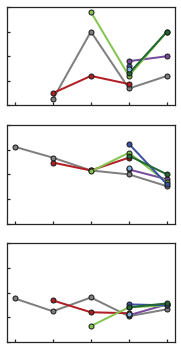

In [18]:
#sns.set_style("white")
sns.set(font_scale = .5, style = 'white')
fig01, ax = plt.subplots(3,1, figsize = (3, 6))

ax[0]


plot_parallel_coords(literature_tf_values_reset, ax[0], area_colors_lit_n)
plot_parallel_coords(literature_osi_values_reset, ax[1], area_colors_lit_n)
plot_parallel_coords(literature_dsi_values_reset, ax[2], area_colors_lit_n)
#ax[0].set_ylabel('TF (Hz)')
#ax[1].set_ylabel('gOSI')
#ax[2].set_ylabel('DSI')


#x[0].set_ylabel('TF')
ax[0].set_ylim(0,4)
#ax[2].legend(literature_tf_values_reset.index,
 #             fontsize = 'small',
#              loc = 'upper left',
#             bbox_to_anchor=(1, 0.,0.5 , 0.8))

ax[1].set_ylim(0,1)
ax[2].set_ylim(0,1)
ax[0].set_xlim(-0.2,4.2)
ax[1].set_xlim(-0.2,4.2)
ax[2].set_xlim(-0.2,4.2)

ax[0].set_xticks(np.arange(5))
ax[1].set_xticks(np.arange(5))
ax[2].set_xticks(np.arange(5))

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xticklabels([])

ax[0].set_yticks([0,1,2,3,4])

ax[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
ax[2].set_yticks([0, 0.25, 0.5, 0.75, 1])

ax[2].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])

#ax[2].set_xticklabels(['1','2','3','4','5'])
#ax[2].set_xlabel('Study')

ax[0].tick_params(direction = 'in', length = 3, top = 'off', right = 'off')
ax[1].tick_params(direction = 'in', length = 3, top = 'off', right = 'off')
ax[2].tick_params(direction = 'in', length = 3, top = 'off', right = 'off')




In [20]:
literature_tf_values_reset['visual_area'] = literature_tf_values['visual_area']

cell_dat = cell_dat[cell_dat['peak dF/F']< 200] # eliminate cells that have a dF/F over 200%, eliminates 8 cells




In [21]:
X, Y = np.meshgrid(np.arange(100), np.arange(100))
X = X.astype(float) + 1
Y = Y.astype(float) + 1
Z = Y/X

KeyError: 'peak_std'

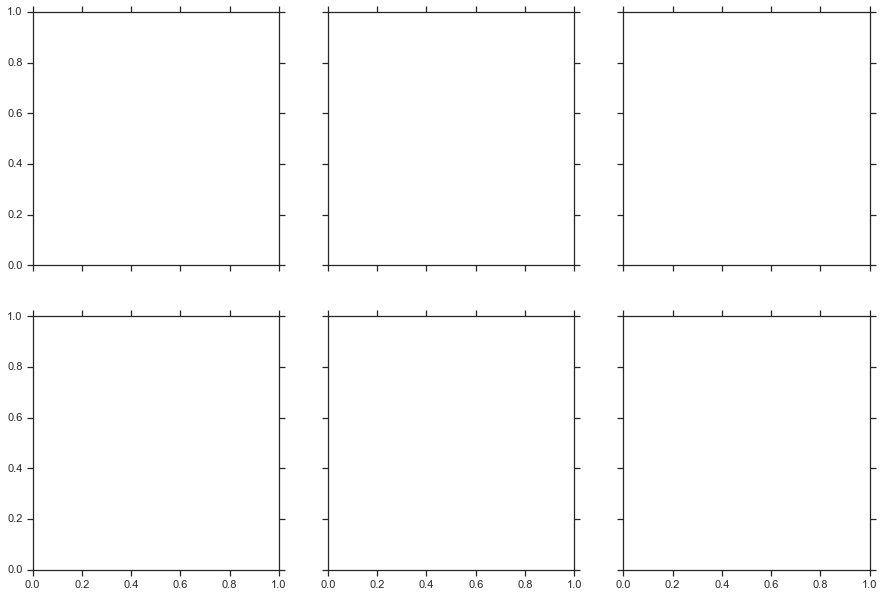

In [23]:
sns.set(font_scale = 1, style = 'white')
fig02, axs = plt.subplots(2,3, figsize = (15,10), sharex = True, sharey = True)

plot_density('peak_std','peak dF/F', cell_dat, axs[0][0])
axs[0,0].set_ylim(0,120)
axs[0,0].tick_params(direction = 'in', length = 5, top="off", right="off")


axs[0,0].set_ylabel('')

axs[0,0].plot(0.25*np.arange(120), color = 'k', zorder = 0)

axs[0,0].plot(0.5*np.arange(120), color = 'k', zorder = 0)
axs[0,0].plot(np.arange(120), color = 'k', zorder = 0)
axs[0,0].plot(2*np.arange(120), color = 'k', zorder = 0)
axs[0,0].plot(4*np.arange(120), color = 'k', zorder = 0)


axs[0,0].set_xticks([0, 25, 50, 75, 100])
axs[0,0].set_yticks([0, 25, 50, 75, 100])

axs[0,0].set_xticklabels([])
axs[0,0].set_yticklabels([])


for ii, ax in enumerate(axs.reshape(-1)[1:]):
    
    
    
    
    sns.regplot(x = 'peak_std', 
                y = 'peak dF/F', 
                fit_reg = False,
                data = cell_dat, 
                color = [0.5,0.5,0.5], 
                marker = '.', 
                scatter_kws = {"s": 100, "alpha": 0.5}, 
                ax = ax)
    
    
    ax.plot(0.25*np.arange(120), color = 'k', zorder = 0)

    ax.plot(0.5*np.arange(120), color = 'k', zorder = 0)
    ax.plot(np.arange(120), color = 'k',zorder = 0)
    ax.plot(2*np.arange(120), color = 'k', zorder = 0)
    ax.plot(4*np.arange(120), color = 'k', zorder = 0)


    
    plot_density('peak_std',
                 'peak dF/F',
                 cell_dat[cell_dat[criteria_ordered[ii]]==True],
                 ax = ax)
    #ax.set_title(studies_ordered[ii])
    ax.set_xlim(0,120)
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.tick_params(direction = 'in', length = 5,  top="off", right="off")
    
    ax.set_xticks(np.arange(0, 120, 30))
    ax.set_yticks(np.arange(0, 120, 30))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    
for ii, ax in enumerate(axs.reshape(-1)[:3]):
    ax.set_xlabel('')

for ii, ax in enumerate(axs.reshape(-1)[1:3]):
    ax.set_ylabel('')
    
for ii, ax in enumerate(axs.reshape(-1)[4:]):
    ax.set_ylabel('')
    

#ax.text(0.5, 0.5, '2',)


#fig02.savefig(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\Figure2.eps")

In [ ]:
observatory_vas = rel_vs_resp_all['area'].unique()
pref_tf_df = pd.DataFrame(index = observatory_vas, columns = criteria)
pref_osi_df = pd.DataFrame(index = observatory_vas, columns = criteria)
pref_dsi_df = pd.DataFrame(index = observatory_vas, columns = criteria)


def convert_tf(df):
    df[df == 1] = 0
    df[df == 2] = 1
    df[df == 3] = 2
    df[df == 4] = 3
    df[df == 5] = 4
    return df

for crit in criteria:
    for va in observatory_vas:
        tf_vals = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)]['TF']
        tf_vals = convert_tf(tf_vals)
        pref_tf_df.loc[va, crit] = tf_vals.mean()
        
        osi_vals = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)]['gOSI']
        pref_osi_df.loc[va, crit] = osi_vals.mean()
        
        dsi_vals = rel_vs_resp_all[(rel_vs_resp_all['area']==va) & (rel_vs_resp_all[crit] == True)]['DSI']
        pref_dsi_df.loc[va, crit] = dsi_vals.mean()

In [ ]:
pref_tf_df = pref_tf_df[literature_order]
pref_osi_df =pref_osi_df[literature_order]
pref_dsi_df = pref_dsi_df[literature_order]


pref_tf_df.columns = studies
pref_osi_df.columns = studies

pref_osi_df.columns = studies

pref_tf_df = 2**(pref_tf_df-1)

In [ ]:
sns.set(font_scale = 0.5, style = 'white')
fig03, axs = plt.subplots(3,1, figsize = (3, 6))


for ii, va in enumerate(pref_tf_df.index):
    axs[0].plot(np.arange(len(pref_tf_df.columns)),
              pref_tf_df.loc[va],
              color = area_colors_n[ii],
              mec = 'k',
              lw = 2,
              marker = 'o',
              ms = 5,
              mew =1,
              label = va)
    
#axs[0].set_ylabel('TF (Hz)')
#axs[0].set_xticks([])
#axs[0].set_xticklabels(['Study 1', 'Study 2', 'Study 3', 'Study 4', 'Study 5'])
axs[0].set_xlim(-0.2, 4.2)    
    
for ii, va in enumerate(pref_osi_df.index):
    axs[1].plot(np.arange(len(pref_osi_df.columns)),
              pref_osi_df.loc[va],
              color = area_colors_n[ii],
              mec ='k',
              lw = 2,
              marker = 'o',
              ms = 5,
              mew =1,
              label = va)

#axs[1].set_ylabel('OSI')
#axs[1].set_xticks([])
#axs[1].set_xticklabels(['Study 1', 'Study 2', 'Study 3', 'Study 4', 'Study 5'])
axs[1].set_xlim(-0.2, 4.2)    


for ii, va in enumerate(pref_dsi_df.index):
    axs[2].plot(np.arange(len(pref_dsi_df.columns)),
              pref_dsi_df.loc[va],
              color = area_colors_n[ii],
              mec = 'k',
              lw = 2,
              marker = 'o',
              ms = 5,
              mew =1,
              label = va)
    
#axs[2].set_ylabel('DSI')
axs[2].set_xticks([0,1,2,3,4])
axs[2].set_xticklabels(['Study 1', 'Study 2', 'Study 3', 'Study 4', 'Study 5'])
axs[2].set_xlim(-0.2, 4.2)    
    
#axs[2].legend(area_order_lit,
 #             fontsize = 'small',
  #            loc = 'upper left',
   #          bbox_to_anchor=(1, 0.,0.4 , 0.6))
axs[2].set_ylim(0,1)
axs[1].set_ylim(0,1)

axs[0].set_xticklabels([])
axs[1].set_xticklabels([])

axs[0].set_ylim(0,4)
axs[0].set_yticks([0,1,2,3,4])

axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[2].set_yticks([0, 0.25, 0.5, 0.75, 1])
#axs[0].set_yticklabels(, decimals = 1))


axs[2].set_xticklabels([])
axs[0].set_yticklabels([])
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

#ax[2].set_xticklabels(['1','2','3','4','5'])
#ax[2].set_xlabel('Study')

axs[0].tick_params(direction = 'in', length = 3, top = 'off', right = 'off')
axs[1].tick_params(direction = 'in', length = 3, top = 'off', right = 'off')
axs[2].tick_params(direction = 'in', length = 3, top = 'off', right = 'off')






In [ ]:
rel_vs_resp_all = rel_vs_resp_all.reset_index()

In [ ]:
rel_vs_resp_all['coeff_var'] = rel_vs_resp_all['peak_std']/rel_vs_resp_all['peak dF/F']
rel_vs_resp_all['fano_factor'] = rel_vs_resp_all['peak_var']/rel_vs_resp_all['peak dF/F']

In [ ]:
rel_vs_resp_V1 = rel_vs_resp_all[rel_vs_resp_all.area == 'VISp']
rel_vs_resp_AL = rel_vs_resp_all[rel_vs_resp_all.area == 'VISal']
rel_vs_resp_PM = rel_vs_resp_all[rel_vs_resp_all.area == 'VISpm']
rel_vs_resp_AM = rel_vs_resp_all[rel_vs_resp_all.area == 'VISam']
rel_vs_resp_RL = rel_vs_resp_all[rel_vs_resp_all.area == 'VISrl']
rel_vs_resp_LM = rel_vs_resp_all[rel_vs_resp_all.area == 'VISl']


In [ ]:
def get_projection(rel_vs_resp):
    slope, intercept, r_value, p_value, std_err = st.linregress(rel_vs_resp['peak_std'],
                                                               rel_vs_resp['peak dF/F'])
    
    
    
    rel_vs_resp_pairs = zip(rel_vs_resp['reliability'].values, rel_vs_resp['peak dF/F'].values)
    rel_vs_resp['projection'] = [np.dot(x, [1,slope]) for x in rel_vs_resp_pairs]
    return rel_vs_resp

def get_sorted_df(rel_vs_resp, sort_by = 'projection', percentiles = (np.arange(20)+1)*5, ascending = False):

    if sort_by == 'projection':
        rel_vs_resp = get_projection(rel_vs_resp)
    resp_sorted_df = pd.DataFrame(index = percentiles, columns = ['tf','dsi','osi'])
    ncells = rel_vs_resp.shape[0]
    sorted_rvr = rel_vs_resp.sort_values(sort_by, ascending = ascending)
    #sorted_rvr['TF'] = convert_tf(sorted_rvr['TF'])
    for p in percentiles: 
        to_get = int(-p/100. * ncells)
        resp_sorted_df.loc[p, 'TF'] = sorted_rvr['TF'][to_get:].mean()
        resp_sorted_df.loc[p, 'gOSI'] = sorted_rvr['gOSI'][to_get:].mean()
        resp_sorted_df.loc[p, 'DSI'] = sorted_rvr['DSI'][to_get:].mean()
        resp_sorted_df.loc[p, 'dsi'] = sorted_rvr['dsi'][to_get:].mean()
        resp_sorted_df.loc[p, 'dsi_thresh'] = sorted_rvr['dsi_thresh'][to_get:].mean()
        resp_sorted_df.loc[p, 'dsi_blank'] = sorted_rvr['dsi_blank'][to_get:].mean()
        resp_sorted_df.loc[p, 'dsi_blank_thresh'] = sorted_rvr['dsi_blank_thresh'][to_get:].mean()
        resp_sorted_df.loc[p, 'TF_std'] = np.std(sorted_rvr['TF'][to_get:])
        resp_sorted_df.loc[p, 'gOSI_std'] = np.std(sorted_rvr['gOSI'][to_get:])
        resp_sorted_df.loc[p, 'DSI_std'] = np.std(sorted_rvr['DSI'][to_get:])
        resp_sorted_df.loc[p, 'dsi_std'] = np.std(sorted_rvr['dsi'][to_get:])
        resp_sorted_df.loc[p, 'dsi_thresh_std'] = np.std(sorted_rvr['dsi_thresh'][to_get:])
        resp_sorted_df.loc[p, 'dsi_blank_std'] = np.std(sorted_rvr['dsi_blank'][to_get:])
        resp_sorted_df.loc[p, 'dsi_blank_thresh_std'] = np.std(sorted_rvr['dsi_blank_thresh'][to_get:])
        
    return resp_sorted_df,sorted_rvr

In [ ]:

resp_sorted_df_all, sorted_rvr_all = get_sorted_df(rel_vs_resp_all,sort_by = 'peak_var')
resp_sorted_df_V1, sorted_rvr_V1 = get_sorted_df(rel_vs_resp_V1, sort_by = 'peak_var')
resp_sorted_df_AL, sorted_rvr_AL = get_sorted_df(rel_vs_resp_AL,sort_by = 'peak_var')
resp_sorted_df_PM, sorted_rvr_PM = get_sorted_df(rel_vs_resp_PM,sort_by = 'peak_var')
resp_sorted_df_LM, sorted_rvr_LM = get_sorted_df(rel_vs_resp_LM,sort_by = 'peak_var')
resp_sorted_df_RL, sorted_rvr_RL = get_sorted_df(rel_vs_resp_RL,sort_by = 'peak_var')
resp_sorted_df_AM, sorted_rvr_AM = get_sorted_df(rel_vs_resp_AM,sort_by = 'peak_var')

In [ ]:

resp_sorted_df_all, sorted_rvr_all = get_sorted_df(rel_vs_resp_all,sort_by = 'coeff_var')
resp_sorted_df_V1, sorted_rvr_V1 = get_sorted_df(rel_vs_resp_V1, sort_by = 'coeff_var')
resp_sorted_df_AL, sorted_rvr_AL = get_sorted_df(rel_vs_resp_AL,sort_by = 'coeff_var')
resp_sorted_df_PM, sorted_rvr_PM = get_sorted_df(rel_vs_resp_PM,sort_by = 'coeff_var')
resp_sorted_df_LM, sorted_rvr_LM = get_sorted_df(rel_vs_resp_LM,sort_by = 'coeff_var')
resp_sorted_df_RL, sorted_rvr_RL = get_sorted_df(rel_vs_resp_RL,sort_by = 'coeff_var')
resp_sorted_df_AM, sorted_rvr_AM = get_sorted_df(rel_vs_resp_AM,sort_by = 'coeff_var')

In [ ]:
sns.set(font_scale = 2, style = 'white')
fig041, ax = plt.subplots(figsize = (10,7))

y_lim = (0,4)
ax.set_ylim(y_lim)
resp_sorted_df_V1['TF'].plot( ax = ax,color = area_colors_dict['V1'], label = 'mean TF V1', alpha = 0.5)
ax.fill_between(resp_sorted_df_V1['TF'].index,
                 resp_sorted_df_V1['TF']- 1.96 * (resp_sorted_df_V1['TF_std']/ (np.sqrt(sorted_rvr_V1.shape[0]*resp_sorted_df_V1['dsi_blank_std'].index.values* .01))),
                 resp_sorted_df_V1['TF'] + 1.96 * (resp_sorted_df_V1['TF_std']/ (np.sqrt(sorted_rvr_V1.shape[0]*resp_sorted_df_V1['dsi_blank_std'].index.values* .01))),
               color = area_colors_dict['V1'],
                alpha = 0.5)


resp_sorted_df_AL['TF'].plot( ax = ax,color = area_colors_dict['AL'] ,label = 'mean TF AL')

ax.fill_between(resp_sorted_df_AL['TF'].index,
                 resp_sorted_df_AL['TF']- 1.96 * (resp_sorted_df_AL['TF_std']/ (np.sqrt(sorted_rvr_AL.shape[0]*resp_sorted_df_AL['dsi_blank_std'].index.values* .01))),
                 resp_sorted_df_AL['TF'] + 1.96 * (resp_sorted_df_AL['TF_std']/ (np.sqrt(sorted_rvr_AL.shape[0]*resp_sorted_df_AL['dsi_blank_std'].index.values* .01))),
                color = area_colors_dict['AL'],
                alpha = 0.5)


resp_sorted_df_PM['TF'].plot( ax = ax,color = area_colors_dict['PM'], label = 'mean TF PM')

ax.fill_between(resp_sorted_df_PM['TF'].index,
                 resp_sorted_df_PM['TF']- 1.96 * (resp_sorted_df_PM['TF_std']/ (np.sqrt(sorted_rvr_PM.shape[0]*resp_sorted_df_PM['dsi_blank_std'].index.values* .01))),
                 resp_sorted_df_PM['TF'] + 1.96 * (resp_sorted_df_PM['TF_std']/ (np.sqrt(sorted_rvr_PM.shape[0]*resp_sorted_df_PM['dsi_blank_std'].index.values* .01))),
               color = area_colors_dict['PM'],
                alpha = 0.5)




ncells = rel_vs_resp.shape[0]

ax.arrow(rel_vs_resp[rel_vs_resp['Tohmi']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.5,
         0,
         -0.4,
         width = .1, 
         head_length = 0.25,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Sun']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.5,
         0,
         -0.4,
         width = .1, 
         head_length = 0.25,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Andermann']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.5,
         0,
         -0.4,
         width = .1, 
         head_length = 0.25,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Roth']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.5,
         0,
         -0.4,
         width = .1, 
         head_length = 0.25,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Marshel']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.5,
         0,
         -0.4,
         width = .1, 
         head_length = 0.25,color =  'k')

#ax.legend(loc = 'upper left', fontsize = 'xx-small', bbox_to_anchor=(1, 0.,0.4 , 0.6))

#ax.set_xlabel('% of cells included', fontsize = 18)
#ax.set_ylabel('TF', fontsize = 18)

ax.set_yticks([0,1,2,3,4])
ax.set_xticks([5,25,50,75,100])



ax.tick_params(length = 15, top="off", right="off")

ax.set_xticklabels([])
ax.set_yticklabels([])


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#ax.tick_params(bottom="off", left="off", top="off", right="off")
#ax.tick_params(bottom="off", left="off", top="off", right="off")



In [ ]:
fig042, ax = plt.subplots(figsize = (10,7))
y_lim = (0.3,1)
ax.set_ylim(y_lim)

resp_sorted_df_V1['gOSI'].plot( ax = ax,color = area_colors_dict['V1'] ,label = 'mean gOSI V1')


ax.fill_between(resp_sorted_df_V1['gOSI'].index,
                 resp_sorted_df_V1['gOSI']- 1.96 * (resp_sorted_df_V1['gOSI_std']/ (np.sqrt(sorted_rvr_V1.shape[0]*resp_sorted_df_V1['dsi_blank_std'].index.values* .01))),
                 resp_sorted_df_V1['gOSI'] + 1.96 * (resp_sorted_df_V1['gOSI_std']/ (np.sqrt(sorted_rvr_V1.shape[0]*resp_sorted_df_V1['dsi_blank_std'].index.values* .01))),
               color = area_colors_dict['V1'],
                alpha = 0.5)


resp_sorted_df_AL['gOSI'].plot( ax = ax,color = area_colors_dict['AL'] ,label = 'mean gOSI AL')

ax.fill_between(resp_sorted_df_AL['gOSI'].index,
                 resp_sorted_df_AL['gOSI']- 1.96 * (resp_sorted_df_AL['gOSI_std']/ (np.sqrt(sorted_rvr_V1.shape[0]*resp_sorted_df_AL['dsi_blank_std'].index.values* .01))),
                 resp_sorted_df_AL['gOSI'] + 1.96 * (resp_sorted_df_AL['gOSI_std']/ (np.sqrt(sorted_rvr_V1.shape[0]*resp_sorted_df_AL['dsi_blank_std'].index.values* .01))),
               color = area_colors_dict['AL'],
                alpha = 0.5)


resp_sorted_df_PM['gOSI'].plot( ax = ax,color = area_colors_dict['PM'], label = 'mean gOSI PM')

ax.fill_between(resp_sorted_df_PM['gOSI'].index,
                 resp_sorted_df_PM['gOSI']- 1.96 * (resp_sorted_df_PM['gOSI_std']/ (np.sqrt(sorted_rvr_PM.shape[0]*resp_sorted_df_PM['dsi_blank_std'].index.values* .01))),
                 resp_sorted_df_PM['gOSI'] + 1.96 * (resp_sorted_df_PM['gOSI_std']/ (np.sqrt(sorted_rvr_PM.shape[0]*resp_sorted_df_PM['dsi_blank_std'].index.values* .01))),
               color = area_colors_dict['PM'],
                alpha = 0.5)


ax.arrow(rel_vs_resp[rel_vs_resp['Tohmi']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.02,
         0,
         -0.02,
         width = .1, 
         head_length = 0.03,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Sun']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.02,
         0,
         -0.02,
         width = .1, 
         head_length = 0.03,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Andermann']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.02,
         0,
         -0.02,
         width = .1, 
         head_length = 0.03,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Roth']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.02,
         0,
         -0.02,
         width = .1, 
         head_length = 0.03,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Marshel']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.02,
         0,
         -0.02,
         width = .1, 
         head_length = 0.03,color =  'k')

#ax.legend(loc = 'upper_left', fontsize = 'small', bbox_to_anchor=(1, 0.,0.4 , 0.6))

ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticks([5, 25, 50, 75, 100])

ax.set_xlabel('')
ax.set_ylabel('')



ax.tick_params(direction = 'in', length = 15, top="off", right="off")

ax.set_xticklabels([])
ax.set_yticklabels([])

sns.set(font_scale = 2, style = 'white')



In [ ]:
fig043, ax = plt.subplots(figsize = (10,7))
y_lim = (0.3,1.0)
ax.set_ylim(y_lim)
resp_sorted_df_V1['dsi_blank_thresh'] = resp_sorted_df_V1['dsi_blank_thresh'].astype(np.float)
resp_sorted_df_AL['dsi_blank_thresh'] = resp_sorted_df_AL['dsi_blank_thresh'].astype(np.float)
resp_sorted_df_PM['dsi_blank_thresh'] = resp_sorted_df_PM['dsi_blank_thresh'].astype(np.float)

resp_sorted_df_V1['dsi_blank_thresh'].plot( ax = ax,color = area_colors_dict['V1'], label = 'mean dsi V1', alpha = 0.5)

ax.fill_between(resp_sorted_df_V1['dsi_blank_thresh'].index,
                 resp_sorted_df_V1['dsi_blank_thresh']- 1.96 * (resp_sorted_df_V1['dsi_blank_thresh_std']/ np.sqrt(sorted_rvr_V1.shape[0])),
                 resp_sorted_df_V1['dsi_blank_thresh'] + 1.96 * (resp_sorted_df_V1['dsi_blank_thresh_std']/ np.sqrt(sorted_rvr_V1.shape[0])),
               color = area_colors_dict['V1'],
                alpha = 0.5)


resp_sorted_df_AL['dsi_blank_thresh'].plot( ax = ax,color = area_colors_dict['AL'] ,label = 'mean dsi AL')

ax.fill_between(resp_sorted_df_AL['dsi_blank_thresh'].index,
                 resp_sorted_df_AL['dsi_blank_thresh']- 1.96 * (resp_sorted_df_AL['dsi_blank_thresh_std']/ np.sqrt(sorted_rvr_AL.shape[0])),
                 resp_sorted_df_AL['dsi_blank_thresh'] + 1.96 * (resp_sorted_df_AL['dsi_blank_thresh_std']/ np.sqrt(sorted_rvr_AL.shape[0])),
                color = area_colors_dict['AL'],
                alpha = 0.5)


resp_sorted_df_PM['dsi_blank_thresh'].plot( ax = ax,color = area_colors_dict['PM'], label = 'mean dsi PM')

ax.fill_between(resp_sorted_df_PM['dsi_blank_thresh'].index,
                 resp_sorted_df_PM['dsi_blank_thresh']- 1.96 * (resp_sorted_df_PM['dsi_blank_thresh_std']/ np.sqrt(sorted_rvr_PM.shape[0])),
                 resp_sorted_df_PM['dsi_blank_thresh'] + 1.96 * (resp_sorted_df_PM['dsi_blank_thresh_std']/ np.sqrt(sorted_rvr_PM.shape[0])),
               color = area_colors_dict['PM'],
                alpha = 0.5)



ax.arrow(rel_vs_resp[rel_vs_resp['Tohmi']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.02,
         0,
         -0.02,
         width = .1, 
         head_length = 0.03,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Sun']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.02,
         0,
         -0.02,
         width = .1, 
         head_length = 0.03,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Andermann']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.02,
         0,
         -0.02,
         width = .1, 
         head_length = 0.03,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Roth']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.02,
         0,
         -0.02,
         width = .1, 
         head_length = 0.03,color =  'k')

ax.arrow(rel_vs_resp[rel_vs_resp['Marshel']].shape[0]/np.float(ncells)*100,
         y_lim[1]+0.02,
         0,
         -0.02,
         width = .1, 
         head_length = 0.03,color =  'k')

#ax.legend(loc = 'upper_left', fontsize = 'small', bbox_to_anchor=(1, 0.,0.4 , 0.6))

ax.set_yticks([0, 0.25, 0.5, 0.75, 1])


ax.set_xticks([5,25,50,75,100])


ax.tick_params(direction = 'in', length = 15, top="off", right="off")

ax.set_xticklabels([])
ax.set_yticklabels([])

sns.set(font_scale = 2, style = 'white')


In [ ]:

resp_sorted_df_all, sorted_rvr_all = get_sorted_df(rel_vs_resp_all,sort_by = 'coeff_var')
resp_sorted_df_V1, sorted_rvr_V1 = get_sorted_df(rel_vs_resp_V1, sort_by = 'coeff_var')
resp_sorted_df_AL, sorted_rvr_AL = get_sorted_df(rel_vs_resp_AL,sort_by = 'coeff_var')
resp_sorted_df_PM, sorted_rvr_PM = get_sorted_df(rel_vs_resp_PM,sort_by = 'coeff_var')
resp_sorted_df_LM, sorted_rvr_LM = get_sorted_df(rel_vs_resp_LM,sort_by = 'coeff_var')
resp_sorted_df_RL, sorted_rvr_RL = get_sorted_df(rel_vs_resp_RL,sort_by = 'coeff_var')
resp_sorted_df_AM, sorted_rvr_AM = get_sorted_df(rel_vs_resp_AM,sort_by = 'coeff_var')

In [ ]:
sns.set(font_scale = 1.5, style = 'white')
fig044, ax = plt.subplots(1,2,figsize = (12,5))
ax[0].bar([1,2,3,4,5],
          np.histogram(sorted_rvr_V1['TF'][:347].values,
                       bins = [1,2,3,4,5,6])[0],
          color ='#7F7F7F')

ax[0].set_xticks([1,2,3,4,5])
#ax[0].set_xticklabels([1,2,4,8,15])
#ax[0].set_title('Lower decile of robustness')

ax[1].bar([1,2,3,4,5],
          np.histogram(sorted_rvr_V1['TF'][-347:].values, 
                       bins = [1,2,3,4,5,6])[0],
         color = '#7F7F7F')

ax[1].set_xticks([1,2,3,4,5])
ax[1].set_xticklabels([1,2,4,8,15])
#ax[1].set_title('Upper decile of robustness')

ax[0].set_ylim(0,140)
ax[1].set_ylim(0,140)
ax[1].set_xlabel('')
ax[0].set_xlabel('')
ax[0].set_ylabel('')


ax[0].set_yticks(np.arange(0,250, 50))
ax[1].set_yticks(np.arange(0,250, 50))


ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

ax[1].set_yticklabels([])
ax[1].set_xticklabels([])


ax[0].tick_params(direction = 'in', length = 10,  top="off", right="off")

ax[1].tick_params(direction = 'in', length = 10,  top="off", right="off")




In [ ]:
sns.set(font_scale = 1.5, style = 'white')
fig045, ax = plt.subplots(1,2,figsize = (12,5))
bins = np.linspace(0,1,20)
ax[0].bar(bins[:-1],
          np.histogram(sorted_rvr_V1['dsi_thresh'][:347].values,
                       bins = bins)[0],
          color ='#7F7F7F', 
          width = .05)


#ax[0].set_title('Lower decile of robustness')

ax[1].bar(bins[:-1],
          np.histogram(sorted_rvr_V1['dsi'][-347:].values, 
                       bins = bins)[0],
         color = '#7F7F7F',
         width = .05)

#ax[1].set_title('Upper decile of robustness')

ax[0].set_ylim(0,180)
ax[1].set_ylim(0,180)
#ax[1].set_xlabel('DSI')
#ax[0].set_xlabel('DSI')
#ax[0].set_ylabel('Count')

for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(5))
    axi.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    
ax[0].set_yticks(np.arange(0,250, 50))
ax[1].set_yticks(np.arange(0,250, 50))
ax[0].set_xticks([0, 0.25, 0.5, 0.75, 1])
ax[1].set_xticks([0, 0.25, 0.5, 0.75, 1])

ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

ax[0].tick_params(direction = 'in', length = 10,  top="off", right="off")

ax[1].tick_params(direction = 'in', length = 10,  top="off", right="off")

    

    


In [ ]:
sns.set(font_scale = 1.5, style= 'white')
fig046, ax = plt.subplots(1,2,figsize = (12,5))
bins = np.linspace(0,1.0,10)
ax[0].bar(bins[:-1],
          np.histogram(sorted_rvr_V1['gOSI'][:347].values,
                       bins = bins)[0],
          color ='#7F7F7F',
         width = .1)


#ax[0].set_title('Lower decile of robustness')

ax[1].bar(bins[:-1],
          np.histogram(sorted_rvr_V1['gOSI'][-347:].values, 
                       bins = bins)[0],
         color = '#7F7F7F',
         width =.1)


#ax[1].set_title('Upper decile of robustness')

ax[0].set_ylim(0,160)
ax[1].set_ylim(0,160)

#ax[1].set_xlabel('gOSI')
#ax[0].set_xlabel('gOSI')
#ax[0].set_ylabel('Count')

for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(5))
    axi.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    
    
ax[0].set_yticks(np.arange(0,250, 50))
ax[1].set_yticks(np.arange(0,250, 50))
ax[0].set_xticks([0, 0.25, 0.5, 0.75, 1])
ax[1].set_xticks([0, 0.25, 0.5, 0.75, 1])

ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

ax[0].tick_params(direction = 'in', length = 10,  top="off", right="off")

ax[1].tick_params(direction = 'in', length = 10,  top="off", right="off")


    
    


In [ ]:
def plot_parallel_coords(df, ax, color_palette, marker_face_color = None):
    if marker_face_color == None:
        marker_face_color = color_palette
    for ii, va in enumerate(df.index):
        ax.plot(np.arange(len(df.columns)),
                  df.loc[va],
                  color = color_palette[ii],
                  mec = 'k',
                  mfc = marker_face_color[ii],
                  lw = 2,
                  marker = 'o',
                  ms = 5,
                  mew =1,
                  label = va)

In [ ]:
fig051, axs =plt.subplots(3,1, figsize = (3,8))

sns.set(style = 'white')
df_tf = pd.DataFrame(columns = ['low', 'high'], index = area_order)

for area in area_order: 
    rel_vs_resp_sub = rel_vs_resp_all[rel_vs_resp_all['area'] == area]
    resp_sorted_df, sorted_rvr= get_sorted_df(rel_vs_resp_sub, sort_by = 'coeff_var')
    
    ncells = sorted_rvr['TF'].shape[0]
    decile_list = np.zeros(ncells)
    decile_num = ncells/10
    decile_means = np.mean(sorted_rvr['TF'][-decile_num:])
    
    
    df_tf.loc[area, 'low'] = 2**(decile_means-1)
    df_tf.loc[area, 'high'] = 2**(np.mean(sorted_rvr['TF'])-1)
    
    


#for

plot_parallel_coords(df_tf, axs[0], area_colors_n)

axs[0].set_xlim(-0.5, 1.5)
axs[0].set_ylim(0,6.5)
#axs[0].set_ylabel('TF (Hz)')

axs[0].set_xticks([0,1])
axs[0].set_yticks([0, 1.5, 3.0, 4.5, 6])
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])

axs[0].tick_params(direction = 'in', length = 5, top = 'off', right = 'off')
axs[1].tick_params(direction = 'in', length = 5, top = 'off', right = 'off')
axs[2].tick_params(direction = 'in', length = 5, top = 'off', right = 'off')


df2 = pd.DataFrame(columns = ['low', 'high'], index = area_order)

for area in area_order: 
    rel_vs_resp_sub = rel_vs_resp_all[rel_vs_resp_all['area'] == area]
    resp_sorted_df, sorted_rvr= get_sorted_df(rel_vs_resp_sub, sort_by = 'coeff_var')
    
    ncells = sorted_rvr['dsi_thresh'].shape[0]
    decile_list = np.zeros(ncells)
    decile_num = ncells/10
    decile_means = np.mean(sorted_rvr['dsi_thresh'][-decile_num:])
    
    
    df2.loc[area, 'low'] = decile_means
    df2.loc[area, 'high'] = np.mean(sorted_rvr['dsi_thresh'])
    
    


#for

plot_parallel_coords(df2, axs[2], area_colors_n)

axs[2].set_xlim(-0.5, 1.5)
axs[2].set_ylim(0, 1)
#axs[2].set_ylabel('DSI')

axs[2].set_xticks([0,1])

axs[2].set_yticks([0, 0.25, 0.5, 0.75, 1.0])
axs[2].set_xticklabels([])
axs[2].set_yticklabels([])

df3 = pd.DataFrame(columns = ['low', 'high'], index = area_order)

for area in area_order: 
    rel_vs_resp_sub = rel_vs_resp_all[rel_vs_resp_all['area'] == area]
    resp_sorted_df, sorted_rvr= get_sorted_df(rel_vs_resp_sub, sort_by = 'coeff_var')
    
    ncells = sorted_rvr['gOSI'].shape[0]
    decile_list = np.zeros(ncells)
    decile_num = ncells/10
    decile_means = np.mean(sorted_rvr['gOSI'][-decile_num:])
    
    
    df3.loc[area, 'low'] = decile_means
    df3.loc[area, 'high'] = np.mean(sorted_rvr['gOSI'])
    
    


#for

plot_parallel_coords(df3, axs[1], area_colors_n)

axs[1].set_xlim(-0.5, 1.5)
axs[1].set_ylim(0, 1)
#axs[1].set_ylabel('gOSI')

axs[1].set_xticks([0,1])
axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1.0])
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])


fig051.savefig(r"C:\Users\nataliam\Documents\ResponsivenessCriteria\191209\Figure51.pdf")
#ax.legend(loc = 'upper_left', fontsize = 'small', bbox_to_anchor=(1, 0.,0.4 , 0.6))